# CS-6570 Assignment #6 - Neural Networks and Keras

**YOUR NAME HERE**

*Weber State University*

In this, our final assignment, we'll use the Keras library to construct neural networks for some classical datasets. In the process, we'll review and explore the important steps in how you specify and train a neural network. Specifically, we'll use a neural network to:

1. Perform binary classification on a set of reviews from the Internet Movie Database (IMDB).
2. Perform multiclass classification on a set of newswires.
3. Perform numeric prediction on a set of housing data.
4. Perform multiclass classification on a set of images.

The basic process will be the same for all of these - they'll just differ in specifics. But first, let's review the steps we covered in Lecture 22 (our lecture on Keras).

First, you'll want to make sure you've installed TensorFlow. If you haven't, you'll want to run the command below. Note this can take a while. Not hours, but minutes. Also, note you only need to do this once. Once it's installed it's installed on your account, not just on this particular kernal. If you haven't installed it yet, please uncomment and run the command below. If you have, don't uncomment it and skip the line below.

In [ ]:
# pip install tensorflow

Of course, we'll want to import our favorite libraries, this time adding tensorflow and keras:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Note you might get some warning when you import tensorflow. That's OK.

To review the example from Lecture 22, let's import the MNIST handwritten digits dataset.

In [2]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 13s 1us/step


The data is already split into a training set and a test set, but there's no validation set, so we'll create one. Additionally, we'll scale the input features - which are represented as integers from  0 to  255. We'll scale them down to the  0−1 range.

In [3]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

Now, we'll build our model with two layers of 32 nodes.

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
    ])

A few things to note about this neural network:

* It's using the [ReLU](https://keras.io/api/layers/activation_layers/relu/) function as the transfer function for the hidden layers. This is the most popular transfer function for hidden layers.
* It's using [softmax](https://keras.io/api/layers/activation_layers/softmax/) for the output layer, which means each node represents a probability, and they will all sum to $1$. More info [here](https://en.wikipedia.org/wiki/Softmax_function), and if you'd prefer to watch a video about it, you can do so [here](https://www.youtube.com/watch?v=8ah-qhvaQqU).

With this model, we then compile it by specifying the loss function and the optimizer:

In [5]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])

Recall from Lecture 22:

* The "sparse_categorical_crossentropy" loss is used because we have sparse labels (for each instance there is just a target class index, in this case from $0$ to $9$) and the classes are exclusive. If instead we had one-hot vectors we would use the "categorical_crossentropy" loss instead.

* The "sgd" is our old friend stochastic gradient descent. Note the learning rate defaults to $lr = 0.01$, but we could specify it with *optimizer = keras.optimizers.SGD(lr=???)*

* The accuracy just measures the percentage of observations classified correctly.

As in Lecture 22, you can check out these links for more info on [losses](https://keras.io/api/losses/), [optimizers](https://keras.io/api/optimizers/), and [metrics](https://keras.io/api/metrics/).

To train the model, we call the "fit" function, and specify the observations, the targets, the number of epochs, and (optionally) the validation set:

In [6]:
history = model.fit(X_train, y_train, epochs = 30, validation_data=(X_valid,y_valid))

Epoch 1/30
1719/1719 [==============================] - 1s 456us/step - loss: 0.7573 - accuracy: 0.7871 - val_loss: 0.3490 - val_accuracy: 0.9052
Epoch 2/30
1719/1719 [==============================] - 1s 408us/step - loss: 0.3318 - accuracy: 0.9033 - val_loss: 0.2837 - val_accuracy: 0.9174
Epoch 3/30
1719/1719 [==============================] - 1s 410us/step - loss: 0.2820 - accuracy: 0.9181 - val_loss: 0.2458 - val_accuracy: 0.9272
Epoch 4/30
1719/1719 [==============================] - 1s 409us/step - loss: 0.2508 - accuracy: 0.9275 - val_loss: 0.2300 - val_accuracy: 0.9354
Epoch 5/30
1719/1719 [==============================] - 1s 410us/step - loss: 0.2268 - accuracy: 0.9349 - val_loss: 0.2050 - val_accuracy: 0.9406
Epoch 6/30
1719/1719 [==============================] - 1s 410us/step - loss: 0.2081 - accuracy: 0.9396 - val_loss: 0.1892 - val_accuracy: 0.9450
Epoch 7/30
1719/1719 [==============================] - 1s 418us/step - loss: 0.1934 - accuracy: 0.9446 - val_loss: 0.1762 -

The main purpose of running the model is to update the weights, but the output is the history object, which we can use to see how the model changed over time.

We can convert the history object into a dataframe and plot how the measures of interest (loss and accuracy) changed over time for both the training data and validation data:

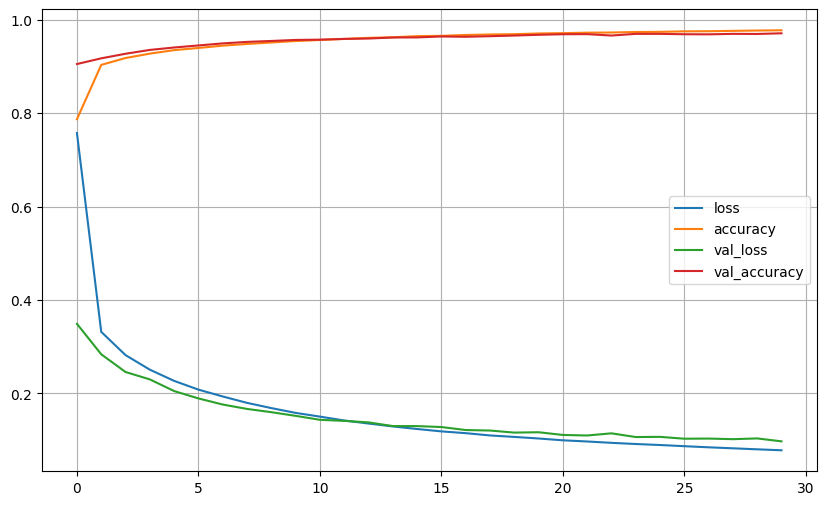

In [7]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.show()

It looks like after about 15 or so epochs our model was fully trained, and further epochs were just overfitting.

Finally, we can see how the trained model does on our testing data:

In [8]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 346us/step - loss: 0.1073 - accuracy: 0.9669


[0.10734418034553528, 0.9668999910354614]

Pretty good!

**Part 1 - Binary Classification of Movie Reviews**

For this first part, we'll work with the IMDB dataset, a set of 50,000 highly polarized reviews from the Internet Movie Database. They're split into 25,000 reviews for training and 25,000 reviews for testing, with each set consisting of 50% negative and 50% positive reviews. Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. The reviews (which are sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary. We can load it with the following commands:

In [9]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 20s 1us/step


Note we pass a "num_words = n" argument to load data here, which allows us to keep only the $n$ most frequent words in the training data. This keeps our data to a more manageable size, and also prevents rare words from causing overfitting in our model. The *train_data* and *test_data* objects are lists of reviews, where each reviews is a list of word indices (which encode a sequence of words). The *train_labels* and *test_labels* objects are lists of $0$s and $1$s, where $0$ stands for *negative* (bad review), and $1$ stands for "positive" (good review).

We can, for fun, decode the reviews and read them with the following code:

In [10]:
word_index = imdb.get_word_index() # This is a dictionary mapping words to an integer index. It's basically the encoder.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # Maps the integers back to words. It's basically a decoder build from our encoder.
decoded_review = " ".join([reverse_word_index.get(i-3,"?") for i in train_data[0]]) #Decodes the review. Note that the indices are offset by 3 because 0, 1, and 2 are reserved for "padding", "start of sequence", and "unknown".
decoded_review

1641221/1641221 [==============================] - 2s 1us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

Seems pretty positive to me! Let's confirm:

In [11]:
train_labels[0]

1

Let's check out another: (Note we switch the review by changing the argument to the *train_data* array in the third line.)

In [12]:
decoded_review = " ".join([reverse_word_index.get(i-3,"?") for i in train_data[2]])
decoded_review

"? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had ? working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life"

So, thumbs down on that one.

In [13]:
train_labels[2]

0

Now, unfortunately for us we can't directly feed these lists of integers into a neural network. They all have different lengths. We can fix this with a *multi-hot encoding*, where we turn each list into a vector of $0$s and $1$s. This would mean, for instance, turning the sequence $[8,5]$ into a 10,000-dimensional vector that would be all $0$s except for indices $8$ and $5$, which would be $1$s. Note we'd lose the information about the order of the words, and just retain which words were used, but that's probably OK for this task.

In [14]:
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i,j] = 1.
    return results
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

So now, our observations are sparse vectors. For example:

In [15]:
X_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels:

In [16]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Now, it's your turn! First, construct a model with three layers (after the input). Two dense, hidden layers with 16 nodes and relu transfer functions, and a final, dense output node with a sigmoid activation function.

In [ ]:
#YOUR CODE HERE
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(10, activation="sigmoid")
    ])

Next, compile your model using the *rmsprop* optimizer and the *binary_crossentropy* loss function. Also, track the accuracy.

In [ ]:
#YOUR CODE HERE

Set aside the first 10,000 observations in the training data as the validation data.

In [ ]:
#YOUR CODE HERE

Finally, fit your model to the remaining training data. Train for 20 epochs and provide the validation data. Also, as we're using *rmsprop* and not *sgd* as our optimizer, we'll want to specify a *batch_size*. Go with a *batch_size* of $512$.

In [ ]:
#YOUR CODE HERE

Then create two plots. The first with training and validation loss. Label your data series.

In [ ]:
#YOUR CODE HERE

The second with the training and validation accuracy. Again, label your data series.

In [ ]:
#YOUR CODE HERE

Retrain the model, and stop after a number of epochs that makes sense based upon your training and validation data.

*Answer* - It looks like the validation accuracy peaks after about 7 epochs.

In [ ]:
#YOUR CODE HERE

How well does this model do on the test data?

In [ ]:
#YOUR CODE HERE

**Part 2 - Multiclass Classification of Newswires**

For this next section, we'll be working with the *Reuters dataset*, a set of short newswires and their topics, published by Reuters in 1986. There are 46 different topics, and some topics are more represented than others, but each topic has at least 10 examples in the training set. Our goal is to train a model to correctly classify each newswire by its topic. In other words, it's a multiclass classification problem.

Like the IMDB reviews, the Reuter's newswire dataset comes packaged with Keras:

In [ ]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

As with the IMDB reviews, we can restrict ourselves to just the $n$ most common words within the dataset, and we restrict ourselves to the top $10,000$.

There are $8,982$ training examples and $2,246$ test examples:

In [ ]:
len(train_data)

In [ ]:
len(test_data)

Again, like the IMDB data, each example is a list of integers:

In [ ]:
train_data[42]

We can decode these lists back to words using the code below, as we did for the IMDB reviews:

In [ ]:
word_index = reuters.get_word_index() # This is a dictionary mapping words to an integer index. It's basically the encoder.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) # Maps the integers back to words. It's basically a decoder build from our encoder.
decoded_newswire = " ".join([reverse_word_index.get(i-3,"?") for i in train_data[25]]) #Decodes the review. Note that the indices are offset by 3 because 0, 1, and 2 are reserved for "padding", "start of sequence", and "unknown".
decoded_newswire

What's the topic here?

In [ ]:
train_labels[25]

The topic number is $1$. OK, but what's that? Well, unfortunately, the Reuters dataset on Keras does not provide a dictionary mapping topic numbers to a description! Seems like something it should have. However, we can find some discussion of it on GitHub [here](https://github.com/keras-team/keras/issues/12072). From here it looks like topic 1 is "grain".

We can vectorize this data using exactly the same functions as in Part 1:

In [ ]:
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Build a three-layer sequential model whole first two layers are dense, hidden layers with 64 nodes and ReLU activation functions. The final, output layer should have a number of nodes corresponding to the number of categories (46), and should us the softmax activation function like we used for the MNIST data above.

In [ ]:
#YOUR CODE HERE

Now, compile the model using the "rmsprop" optimizer, and the "sparse_categorical_crossentropy" loss. Also, store the accuracy metric as we did in the MNIST example.

In [ ]:
#YOUR CODE HERE

Split your training data into a training set and a validation set. This time, only use $1,000$ observations in the validation set.

In [ ]:
#YOUR CODE HERE

Using the training data, train the model for $20$ epochs with a batch size of $512$, and store the training history. 

In [ ]:
#YOUR CODE HERE

Plot the loss and accuracy curves for both the training and validation data. Where does it look like they diverge?

In [ ]:
#YOUR CODE HERE (lOSS CURVES)

In [ ]:
#YOUR CODE HERE (ACCURACY CURVES)

Restart your model, and train it for a more appropriate number of epochs based on what you've found.

In [ ]:
#YOUR CODE HERE

Check the performance of this new model on the test data.

In [ ]:
#YOUR CODE HERE

**Part 3 - Numerical Predictions (Regression) on Housing Data**

In parts 1 and 2 we were dealing with classification problems. Here we'll look at predicting a numeric value instead of a category. In other words, we'll use a neural network to approach a *regression* problem. To do this, we'll use the Boston housing dataset. This is a dataset about neighborhoods in the suburbs of Boston in the mid-1970s. Please note the home values have not been adjusted for inflation - typically they're between \\$10,000 and \\$50,000. This is not the case today!

Each observation is a neighborhood of Boston, and there are a number of data points about the neighborhood, such as its crime rate, its local property tax rate, and so on. We'll be trying to use these data to predict the median house price. Unlike the two previous examples, there are relatively few data points here - only 506, split between 404 training samples and 102 test samples. Also, each feature in the input data has a different scale. For example, the scale used for crime rate is different than the scale used for the property tax rate.

In [ ]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

In [ ]:
train_data.shape

In [ ]:
test_data.shape

So, there are 13 numeric features about each neighborhood that we'll use to predict the median housing value. The targets are these median housing values (for owner-occupied homes) in thousands of dollars:

In [ ]:
test_targets

Before we start training we'll want to normalize the data. In other words, scale each of the features so the values have mean $0$ and standard deviation $1$. You can either do this manually, or with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from sklearn.

In [ ]:
#YOUR CODE HERE

Now, we'll want to build our model. We'll use a model with two dense training layers with 64 nodes each and ReLU activation functions. The final layer will have a single dense node with no specified activation function (so the activation function is just the identity - it doesn't change the data). We'll use *rmsprop* as the optimizer, *mse* as the loss, and track the metric *mae*. Here "mse" stands for "mean squared error", and "mae" stands for "mean absolute error". The mean absolute error is the average of the absolute values of the differences between the predictions and the targets. We'll wrap this up in a function that we can call to create a new model. Also, note that we'll sometimes abbreviate "mean absolute error" using uppercase letters - MAE.

In [ ]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
    return model

Because we don't have much data, instead of just having one validation set, we'll want to use $K$-fold validation. Write code that prepares a list of training and validation sets for $K$-fold validation based on a specified value of $K = 4$. Note you can either create code to do this explicitly, or use the [KFold](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) function in sklearn.

In [ ]:
#YOUR CODE HERE

Write code that fits the model on each training set generated for $K$-fold validation above. Use $100$ epochs and a batch size of $16$. Also, note that if you set "verbose = 0" in your fit command, it won't output the running tally from each epoch, which might be nice in this case. After 100 epochs of training, [evaluate](https://keras.io/api/models/model_training_apis/#evaluate-method) the model on the validation data, and track the MAE for each fold. At the end, calculate the average MAE over all 4 folds. Please note that on each fold you'll need to use a different, reset model.

In [ ]:
#YOUR CODE HERE

Now let's repeat what we did above, except we'll run for 500 epochs on each fold, and we'll track the training history and performance on the validation data. Once training on a given fold is completed extract the MAE history from the history object, and add it to a list of MAE training histories for each fold. Note this might take a few minutes, and you'll *really* want to set *verbose = 0*.

In [ ]:
#YOUR CODE HERE

Create a dataframe of the average value of the validation MAE for each fold after each epoch. So, the first value in your dataframe should be the average value of the validation MAE over all the folds after their first epoch, the second should be the average value of the validation MAE over all the folds after their second epoch, and so on.

In [ ]:
#YOUR CODE HERE

Plot the average validation MAE over the 500 epochs.

In [ ]:
#YOUR CODE HERE

You might notice a bit of a scaling issue here. The validaion MAE is much higher for the first 10 or so training epochs, and then it settles down. So, plot this data again, but exclude the first 10 values. What number of epochs appears to give us the best performance on the validation data?

In [ ]:
#YOUR CODE HERE

Retrain the model using all the training data (nothing left out as validation data) for the optimal number of epochs determined by the chart above.

In [ ]:
#YOUR CODE HERE

Check the performance (the MAE) of this model on the test data. Be sure to scale the test data like you did the training data.

In [ ]:
#YOUR CODE HERE

**Part 4 - Categorical Prediction on the Fashion MNIST Dataset**

The fashion MNIST dataset is an exact replica of the format of the standard MNIST (handwritten digits) dataset, only instead of being images of handwritten numbers, it's images of clothing from a catalog with the following 10 categories:

* 0: T-shirt / top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

For this part of the assignment, you'll upload the fashion MNIST training data from a zip file provided for you on Canvas. You should be able to do so with the following code, assuming the .gz file is in the same directory as this Jupyter notebook. If not, you'll need to modify the path to the file appropriately.

In [ ]:
import sys
import gzip
import shutil

import os
import struct
import numpy as np

import warnings
warnings.filterwarnings("ignore")

zipped_mnist = [f for f in os.listdir() if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], 'wb') as outfile:
        outfile.write(decompressed.read())

def load_mnist(path, kind='train-fashion'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

X_train, y_train = load_mnist('', kind='train-fashion');

OK, now we have two datasets:
* X_train: A set of values between -1 and 1 indicating the amount of grey within a particular pixel.
* y_train: A set of values between 0 and 9 indicating the clothing category of a given image.

We can use matplotlib to visualize the first instance of each class in the data. Note that these images are significantly more sophisticated than the hand-written digits.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

The final part of this assi is more open-ended. You'll want to write code to create a neural network for classifying these images into the appropriate categories. Experiment with the possibilities, and try to build the best one you can. I'll be testing the model your code builds on some distinct testing data. If you can do better than 80% on the test data, you'll get full credit for this section. The entry from the class that does the best will get extra credit. Please explain your modeling decisions. Good luck!

In [ ]:
#YOUR CODE HERE